# Assignment 1 MTA Cardtype Timeseries Analysis Part I
yg833

This assignment is a continuation from the week prior. In the prior week, I worked with a number of colleagues from class - QY (qg412), Jerome (jl9489), Andrea(ah4412), Fekade Brook (fb1182), and Sam (sjf374). Mainly, we worked alongside each other thinking out loud and comparing outputs.

For this week, I worked with QY(qg412), Rachel (rms818), Khloe(kyn227) and Tiffany (tp1600)

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


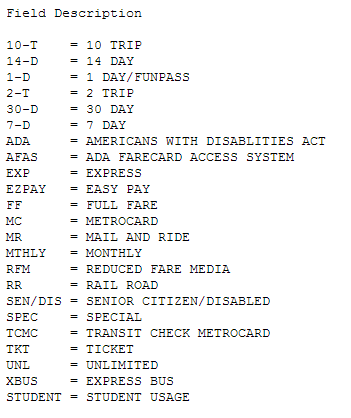

In [1]:
# set up libraries
from __future__ import print_function, division

import os
import sys
import urllib
import io

import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import mixture


%matplotlib inline
%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [2]:
# setting environmental variable
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print(os.environ["PUIDATA"])

/nfshome/yg833/PUIdata


In [3]:
# url for mta fare data
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy' 

# retrieve csv file from the url
urllib.request.urlretrieve(url, 'MTA_Fare.npy')

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7ff15a77b358>)

In [4]:
# move the file to PUIData folder
!mv MTA_Fare.npy $PUIDATA

In [ ]:
mta = np.load(os.environ["PUIDATA"]+'/MTA_Fare.npy')

In [ ]:
shape(mta)

(600, 23, 194)

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

### read in data as instructed above

In [ ]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [ ]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

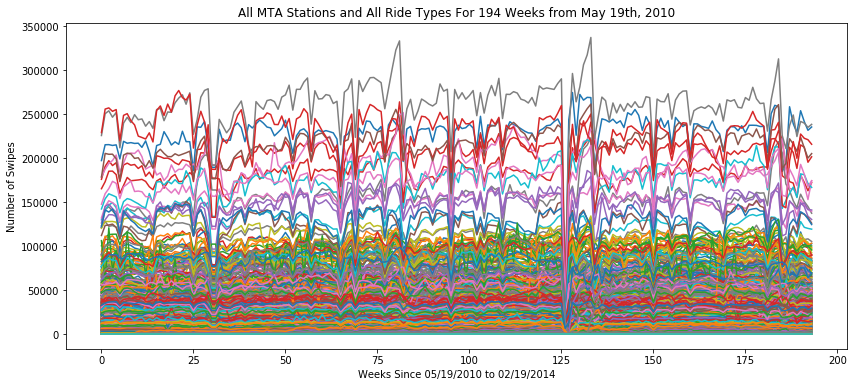

In [ ]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(mta[i,j])

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

### Figure 1: Plot of mta swipes data with x axis as weeks between 05/19/2010 and 02/19/2014. The plot is very messy and kind of hard to read. There appears to be many dips at around (all approximate reads of the x-axis) week 27, week 70, week 90, week 127, week 150 and so on. The obvious valleys were around week 80 and week 130.  

In [ ]:
# convert the mta cube with -1s  into float and convert to nans
mta = mta[:].astype(float)

In [ ]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 2: Time series for all rides types and all stations in semi-log space. The plot is still kind of messy still but easier to read than compared to the one in Figure 1. From this second plot, it seems like the dip was at around week 125. 

In [ ]:
dates_studied = pd.date_range(start = '2010/05/19', periods=194, freq='W-WED') # creats a date range for this analysis

In [ ]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(dates_studied,np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 3: Same as figure 2 but changing the x-axis to read the date of week instead of the week number.

# Task 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 

### MG's note: In class, Dr. Bianco showed several different samples for event detention. So in trying to complete Task 1, event detention, we looked at both the point of change and the FDNY notebooks. 

In [ ]:
# define point of change function from Dr. Bianco's repo
# Dr. Bianco's code
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

In [ ]:
# using the change finder function to find the point of change.
ppoc = changeFinder(mta[0][0])
dates_studied[ppoc['pointOfChange']]

### MG's note: From the point of change function, it looks like that it happened in week 127. So I looked up week 127 from the date range and saw that it correlates to the week of October 24th, 2012

In [ ]:
## flatten the dataframe to sum over the wipes per station per week
mta_sum_by_card_types = np.nansum(mta, axis = 0)
mta_sum_by_wk = np.nansum(mta_sum_by_card_types, axis = 0)

In [ ]:
shape(mta_sum_by_wk)

In [ ]:
print ("mean swipes by week {:.2f}".format(mta_sum_by_wk.mean()))
print ("stdev swipes by week {:.2f}".format(mta_sum_by_wk.std()))
thresholds = [mta_sum_by_wk.mean() + 3 * mta_sum_by_wk.std(), 
              mta_sum_by_wk.mean() - 3 * mta_sum_by_wk.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))


In [ ]:
thresholds

In [ ]:
mta_sum_by_wk = pd.DataFrame(mta_sum_by_wk, columns=['sum_swipes_weekly'])
mta_sum_by_wk['week_of'] = dates_studied

In [ ]:
mta_sum_by_wk.head()

In [ ]:
# this was adapted from dr. bianco's FDNYdeaths notebook
ax = mta_sum_by_wk['sum_swipes_weekly'].plot(logy=True, figsize=(15,5), style=".")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k', label = '3 Sigma Threshold')
pl.plot(mta_sum_by_wk['sum_swipes_weekly'], 'bo', label = 'Sum of Swipes Weekly')
pl.xticks(np.arange(0, 195, step=5), rotation=45, fontsize=15)
pl.yticks(fontsize=10)
pl.ylabel("Log Number of Swipes", fontsize=20)
pl.xlabel("Weeks", fontsize=20)
pl.title("Plot of Weeks Since 05/19/2010 vs. Log Number of Swipes")
pl.legend(loc = 3)

### Figure 4: Looking at the plot above it looks like that around week 125, there is an event which is > 3 sigmas from the whole time series. Finding that value in the array, it is at around week 127 with 5215466 swipes total that week.

In [ ]:
Image(filename = "Sandy.PNG")

# Task 2: Finding Trends

## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [ ]:
## flatten the dataframe to take the mean over the swipes per station per weeks
mta_mean_by_card_types = np.nanmean(mta, axis = 0)
shape(mta_mean_by_card_types)

In [ ]:
mta_mean_by_card_types_df = pd.DataFrame(mta_mean_by_card_types,
                                         index = ridetype).T # transpose the matrix

In [ ]:
mta_mean_by_card_types_df.head(5) # just to see if the df looks right

In [ ]:
mta_mean_by_card_types_df.describe()

In [ ]:
pl.figure(figsize(20,10))

for i in ridetype:
    pl.plot(dates_studied, mta_mean_by_card_types_df[i])
pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Average of Swipes Per Station')
pl.legend(loc = 0)
pl.title('All MTA Stations and Card Type For 194 Weeks from May 19th, 2010')

### Figure 5: Plot of the Weeks Since 05/19/2010 vs Average Swipes Per Station For each Card Type

In [ ]:
mta_rolling_mean_by_card_types_df = mta_mean_by_card_types_df.rolling(20, min_periods=5).mean()

In [ ]:
mta_rolling_mean_by_card_types_df.head()

In [ ]:
for i in ridetype:
    pl.figure(figsize(10,5))
    pl.plot(dates_studied, mta_mean_by_card_types_df[i], label = 'Mean for Card Type')
    pl.plot(dates_studied, mta_rolling_mean_by_card_types_df[i], label = 'Rolling Mean for Card Type (smooth)')
    pl.xlabel('Weeks Since 05/19/2010', fontsize = 10)
    pl.ylabel('Average of Swipes Per Station', fontsize = 10)
    pl.legend(loc = 0, fontsize = 10)
    pl.title('Card Type: '+ i + ' For 194 Weeks from May 19th, 2010 Across 600 MTA Stations', fontsize = 12)

### Figure 6: 23 Individual Plots for Each Card Type where both the means and the rolling means are graphed. The *blue* lines are showing the means and the *orange* lines are showing the rolling means. From the plots above it looks like there are some card types that have experienced increases and some that have experienced declines. 

* Increases:
    *14d (1)
    *7d (5)
    *mc (11)
    *mr (12)
    *rr (15)
    *sen (16)
    *spec (17)
    *tcmc (18)
    
* Declines:
    *afas (7)
    *exp (8)
    *ez (9)
    *month (13)
    *rfm (14)

In [ ]:
first_ten = mta_mean_by_card_types_df.iloc[0:10,:].sum()

In [ ]:
last_ten = mta_mean_by_card_types_df.iloc[184:194, :].sum()

In [ ]:
card_stdev = np.std(mta_mean_by_card_types_df)

In [ ]:
diff_first_last = last_ten - first_ten

In [ ]:
ratio_change = (diff_first_last/ first_ten)

In [ ]:
res_ratio = pd.concat([first_ten, last_ten,card_stdev, diff_first_last, ratio_change], 
                      axis=1, 
                      sort=False)

res_ratio.columns = ['first_ten', 'last_ten', 'card_stdev','diff_first_last', 'ratio_change']

In [ ]:
res_ratio.sort_values('ratio_change')

### The table above shows the change ratios sorted from steepest decline to steepest increase.

# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features - models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 

## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [ ]:
# reading more about how to handle nans in pythonic way
# https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html
# https://www.python-course.eu/numpy_masking.php
shape(mta)

In [ ]:
mta[mta == -1] = np.nan

In [ ]:
mta_2d_w = mta.reshape(600*23, 194)
shape(mta_2d_w)

In [ ]:
# find the location for nans in the time series
find_nans = np.any(np.isnan(mta_2d_w), axis = 1)
shape(find_nans)

In [ ]:
shape(mta_2d_w[~find_nans]) # this one doesn't filter out the zeros

In [ ]:
# find the ind where nans and zeros are NOT present, 
# this the method providesd by Dr. Bianco
find_nans_zeros = mta.reshape(600*23, 194).std(1) > 0
shape(find_nans_zeros)

In [ ]:
# create total time series excluding the nans and zeros
tots = mta_2d_w[find_nans_zeros]
shape(tots)

In [ ]:
shape(mta_2d_w[~find_nans_zeros])

#### mg note: looks like we filter out 6140 ts

In [ ]:
# find the mean per timeseries
ts_mean = np.nanmean(tots, axis = 1)

In [ ]:
# find the standard deviation per timeseries
ts_std = np.nanstd(tots, axis = 1)

#### mg note
### feature: standardized number of rides per ts

In [ ]:
# find the standardize number of rides per timeseries
# y = (x - mean) / standard_deviation
# from https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

standardized_ts = np.empty_like(tots)

for i in range(len(tots)):
    for j in range(len(tots[i])):
        standardized_ts[i][j] = ((tots[i][j] - ts_mean[i])/ts_std[i])

In [ ]:
standardized_ts

In [ ]:
shape(standardized_ts)

In [ ]:
pl.figure(figsize(10,8))
for i in range(10):
    pl.plot(standardized_ts[i])
pl.xlabel("week number", fontsize = 12)
pl.ylabel("standardized number of rides", fontsize = 12)
pl.title("Week Number Since 05/09/2010")

### Figure 7: X axis shows the weeks since May 19th 2010 and the y axis shows the values for the standardized # of rides per time series. Only the 1st ten time series were plotted in the chart above. There are over 9000 time series in the data set. Lastly, the graph above also shows the drop/ event change around week 125 which is what was identified in task 2. 

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


### mg note: 
### features: slope and intercept

In [ ]:
# followed the guide below for directions on how to fit a line to the data
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

allfits = []
wks = np.array(range(194)) # the x axis is weeeks
wks = sm.add_constant(wks) # add a constant, this will be the intercept

for i in range(len(standardized_ts)):
    model = sm.OLS(standardized_ts[i], wks)
    allfits.append(model.fit())
    

In [ ]:
print(allfits[0].summary()) # to just see 1

In [ ]:
[a.params[0] for a in allfits[:10]] # to see the coef of the first 10, this is the slope of the line

In [ ]:
[a.params[1] for a in allfits[:10]] # to see the coef of the first 10, this is the contant added of the line

### mg note: make features for 
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station


In [ ]:
print('timeseries means: ',ts_mean, '\n timeseries mean shape: ' ,shape(ts_mean))
print('timeseries std: ',ts_std, '\n timeseries std shape: ',shape(ts_std))
# just to remind myself of what was the time series means and std

In [ ]:
# this is how Dr. Bianco got station ids
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid_no_nans = stationid[mta.reshape(600 * 23, 194).std(1) > 0]
shape(stationid_no_nans)

In [ ]:
stationid_no_nans ### given cube nature the 1st indice should be repeated

In [ ]:
# create an array that index / label the card types
ridetype_label = np.tile(np.array(range(23)),600)
label = ridetype_label[find_nans_zeros]
shape(label)

In [ ]:
label[:50]

In [ ]:
# find means per station
stationsmeans = np.nanmean(mta.reshape(600, 23 * 194), axis=1)    
shape(stationsmeans)

In [ ]:
# find std per station
stationsstd = np.nanstd(mta.reshape(600, 23 * 194), axis = 1)  
shape(stationsstd)

In [ ]:
# 600 stations, find means per station
normedtsmean = np.ones(shape(stationid_no_nans)).astype(float)
normedtsstd = np.ones(shape(stationid_no_nans)).astype(float)

for i in range(600):
    ai = np.where(np.isin(stationid_no_nans, i)) 
    # creates an array of 1d with the indices of the array reflecting values from that specific subway station
    for j in ai[0]:
        normedtsmean[j] = tots[j].mean() / stationsmeans[i]
        normedtsstd[j] =  tots[j].std() / stationsstd[i]   

### MG's Note: Split the standardized data into training and testing data sets

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
# array of 4 features in order:
# slope of line, x- intercept, mean of ts/ normedtsmean, std of ts/ normedtsstd
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
np.mean(tots)


In [ ]:
pl.plot(X_train[:,1], X_train[:,3], '.')

In [ ]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [ ]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

#### mg notes: random forest classifier
from https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
"Random Forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model."

In [ ]:
clf = rfc(random_state = 10)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test,y_test)

In [ ]:
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

#### Figure 8: Confusion matrix on the performance of the classifier and the score was 0.95 for the training dataset obtained using an out-of-bag estimate.

 #### use classification_report to assess the model and clf.feature_importances_ to find the important features

In [ ]:
print(classification_report(y_test, y_pred, target_names=ridetype[:-1]))

In [ ]:
clf.feature_importances_

# slope of line, x- intercept, mean of ts/ normedtsmean, std of ts/ normedtsstd


In [ ]:
shape(np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]))

#### mg note:
#### classification report: Precision score looks high on average at 0.75 with a range of 0 to 0.99. Some were very low because the number of ts after cleaning out the nans were much smaller. that makes sense
#### feature importance: looks like the most important feature is the mean of normedtsmean

## Build a model that uses as input features each time stamp (194 features) :


In [ ]:
# use the same split ratio
# the tots array is already organized in the shape of (7660,194)
X_train2, X_test2, y_train2, y_test2 = train_test_split(tots, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
np.array(X_train2).shape, np.array(X_test2).shape, np.array(y_train2).shape, np.array(y_test2).shape

In [ ]:
(~np.isfinite(X_train2)).sum(),(~np.isfinite(X_test2)).sum(),(~np.isfinite(y_train2)).sum(),(~np.isfinite(y_test2)).sum()

In [ ]:
clf.fit(X_train2, y_train2)

In [ ]:
clf.score(X_train2,y_train2)

In [ ]:
y_pred2 = clf.predict(X_test2)

In [ ]:
imshow(confusion_matrix(y_test2, y_pred2))

#### Figure 9: Confusion matrix on the performance of the classifier and the score was 0.99 for the training dataset obtained using an out-of-bag estimate.

In [ ]:
print(classification_report(y_test2, y_pred2, target_names=ridetype[:-1]))

In [ ]:
print(clf.feature_importances_) # importance of the features, each of the 194 weeks

In [ ]:
feature_imp2 = clf.feature_importances_

In [ ]:
pl.figure(figsize(30,5))
pl.plot(feature_imp2)
pl.xlabel("week number", fontsize = 12)
pl.ylabel("standardized number of rides", fontsize = 12)
pl.title("Week Number Since 05/09/2010")

### Figure 10: Plot of feature importance with each week as a feature

#### mg note:
#### classification report: Precision score looks high on average at 0.78 with a range of 0 to 1.00. Some were very low because the number of ts after cleaning out the nans were much smaller. that makes sense
#### feature importance: From the features it looks like about week 30, 40, and 125 were of high importance

# Assignment 1 MTA Cardtype Timeseries Analysis Part II
yg833

This assignment is a continuation from the week prior.For this week, I worked with QY(qg412)


# Task 4: Fourier transform
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**

from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [ ]:
station_sums = np.nansum(mta, axis=1) # sum per station across 194 weeks
print(shape(station_sums), '\n', station_sums)

In [ ]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT) 
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).
# 600 stations, find rfft per station
station_dft = (np.abs(np.fft.rfft(station_sums, axis = 1))**2) # power spectrum, square for absolute value

# https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb
print(shape(station_dft), '\n', station_dft)

In [ ]:
N = len(mta[0][0])
N
# since we are measuring in weeks, the smallest unit would be 2 weeks

In [ ]:
# plot all 600 stations from the series named station_dft (discreet fourier transformations)

print ("There are n=%d datapoints in the series"%N)

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], '-')

pl.xlabel('frequency (1/week)', fontsize=10)
pl.ylabel('power', fontsize=10)
pl.title('Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks', fontsize=15)

### Figure 11: In the power spectrum above of total rides for each of the 600 stations over 194 week, we see on the x-axis is in units of inverse frequencies. Therefore further from the 0,0 point, its 2 weeks (the smallest unit).

In [ ]:
print (" The first two frequency (slowest) calculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate id every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

#### mg note: seeing the above for slowest, it makes sense to drop the first index value which is inf

In [ ]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

# pl.xlim(0,0.05)
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (1/frequency)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 12: From the above chart, it seems like the high periodicity between 3.3333 and 4.999 period after dropping the first FFT value.

In [ ]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (weeks)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

### Figure 13: In the above plot the first value of the FFT is dropped, and zoomed into the weeks. Showing that at around 33 weeks, there is high periodicity

In [ ]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/4/f) for f in ax.get_xticks()], fontsize=10)  # divide by 4 because to get the months from 33 weeks
pl.xlabel("period (month)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 14: Adjusting the x-scale from plot 4 to read months. So its just about 8 months where we see high periodicity

### Identify Stations

From the charts above, we see that there is high periodicity at about 52 weeks. We want to find where the top 4 stations demonstrating the highest periodicity at each 52 weeks. 

In [ ]:
freq = np.fft.rfftfreq(N, 1.0)
shape(freq)

In [ ]:
1/freq[4]

In [ ]:
expected_freq = 1/52
expected_freq # because on annual period so freq is 1/52

The freq and the expected freq is similar

In [ ]:
number_times_repeated = np.where(np.abs(freq - 1.0/52) == min(np.abs(freq - 1.0/52)))[0]
number_times_repeated

In [ ]:
(N/number_times_repeated)[0]

In [ ]:
194/4

In [ ]:
# each period is 48.5 weeks

In [ ]:
find_4th = np.empty([600])
for i in range(len(station_dft)):
    find_4th[i] = station_dft[i][4]

In [ ]:
find_4th.argsort()[-4:][::-1] # the index of the stations

In [ ]:
ided_stations = [0, 194, 150, 327]
len(ided_stations)
ided_stations[3]
for i in range(0, 4):
    fig=pl.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    ax.plot(station_sums[ided_stations[i]])
    pl.xlabel("Weeks Since May 19th, 2010", fontsize=15)
    pl.ylabel("Sum of Rides", fontsize=15)
    pl.title("Plot of Rides at Station ID: " + str(ided_stations[i]) , fontsize=15)

### Figure 15: Plot of each of the identified stations to further inspect for periodicity for the duration of sum rides from May 19, 2010

# Task 5: Extra Credit
**Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:**
- are there distinct clusters?
- do they reflect the card type or station? 

To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: 
subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead: 

observation = (observation -observation.mean()) / observation.std()
each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

see this regarding whitening: https://github.com/fedhere/UInotebooks/blob/master/cluster/whitening.md

In [ ]:
ts_w_4_feats = np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(tots)/normedtsmean, np.std(tots)/normedtsstd]).T

In [ ]:
shape(ts_w_4_feats)

In [ ]:
# find the mean per feature
ft_mean = np.nanmean(ts_w_4_feats, axis = 1)

In [ ]:
# find the std per feature
ft_std = np.nanstd(ts_w_4_feats, axis = 1)

In [ ]:
# find the standardize number of rides per timeseries
# y = (x - mean) / standard_deviation
# from https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

standardized_ft = np.empty_like(ts_w_4_feats)

for i in range(len(ts_w_4_feats)):
    for j in range(len(ts_w_4_feats[i])):
        standardized_ft[i][j] = ((ts_w_4_feats[i][j] - ft_mean[i])/ft_std[i])

In [ ]:
### adapted from https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method
distorsions = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(standardized_ft)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
pl.plot(range(1, 5), distorsions)
pl.grid(True)
pl.xlabel('Number of Clusters')
pl.ylabel('Average within-cluster sum of squares')
pl.title('Elbow curve')

### Figure 16: Elbow Curve of K Clusters and determine the optimal number of clusters as discussed in class. Looks to at 3

In [ ]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
shape(standardized_ft)

In [ ]:
#cluster with kmeans
nc = 3 # setting the number of clusters
km = KMeans(n_clusters=nc, random_state=444).fit(standardized_ft)
y_km = kmeans.predict(standardized_ft)

In [ ]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
print(km.labels_.shape, km.labels_)

In [ ]:
km.cluster_centers_ # this gives you the cluster centers

In [ ]:
cluster_labels = km.labels_

In [ ]:
for i in range(nc):
    fig=pl.figure(figsize=(8,4))
    ax=fig.add_subplot(111)
    ax.plot(standardized_ft[cluster_labels == i])    
    ax.set_title('Cluster ' + str(i))
    ax.set_xlabel('?')
    ax.set_ylabel('?')
    plt.tight_layout()